In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sbn
import numpy as np 

import torch

import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score, silhouette_samples
import umap
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

from amlvae.models.VAE import VAE 
from amlvae.train.Trainer import Trainer

from amlvae.data.ExprProcessor import ExprProcessor
from amlvae.data.ClinProcessor import ClinProcessor

from sklearn.model_selection import KFold

from sklearn.metrics import pairwise_distances

import torch

from torch.nn import TransformerEncoder, TransformerEncoderLayer


# auto reimport 
%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
expr_long = pd.read_csv('../../data/aml_train.csv')
clin = pd.read_csv('../../data/beataml_clinical_for_inputs.csv')
eproc = ExprProcessor(expr_long, target='fpkm_unstranded', norm='zscore_log2', top_genes=5000)
cproc = ClinProcessor(clin.set_index('gdc_id'), targets=['specimenType', 'consensus_sex', 'reportedRace'])
# cohort (waves 1+2, waves 3+4)

In [3]:
X_train, train_ids = eproc.get_data()
X_train = torch.tensor(X_train, dtype=torch.float32)

cond_train = cproc.get_data(train_ids)
cond_meta = {targ: cond_train[targ].shape[1] for targ in cond_train}
cond_train = {targ: torch.tensor(cond_train[targ].argmax(1), dtype=torch.long).view(-1) for targ in cond_train}

In [4]:
X_val, val_ids = eproc.process_new(pd.read_csv('../../data/aml_validation.csv'))
X_val = torch.tensor(X_val, dtype=torch.float32)


In [5]:
X_test, test_ids = eproc.process_new(pd.read_csv('../../data/aml_test.csv'))
X_test = torch.tensor(X_test, dtype=torch.float32)

In [6]:
class AmlDataset(torch.utils.data.Dataset):
    def __init__(self, X, gene_names, vocab, dropout=0, topk=1000):
        self.X = X
        self.gene_names = gene_names
        self.vocab = vocab
        self.token2idx = {t: i for i, t in enumerate(vocab)}
        self.dropout = torch.nn.Dropout(dropout)
        self.topk = topk

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        x = self.dropout( self.X[idx] )
        sorted_ixs = torch.argsort(x, descending=True)[:self.topk]
        tokens = self.gene_names[sorted_ixs].tolist() + ['<cls>']
        seq1 = torch.tensor([self.token2idx[t] for t in tokens], dtype=torch.long)

        x = self.dropout( self.X[idx] )
        sorted_ixs = torch.argsort(x, descending=True)[:self.topk]
        tokens = self.gene_names[sorted_ixs].tolist() + ['<cls>']
        seq2 = torch.tensor([self.token2idx[t] for t in tokens], dtype=torch.long)

        return seq1, seq2

In [7]:

class MLP(torch.nn.Module): 

    def __init__(self, in_channels, hidden_channels, out_channels, layers=2, dropout=0, 
                        nonlin=torch.nn.ELU, out=None, norm=torch.nn.LayerNorm): 
        '''
        
        Args: 
            in_channels             int                 number of input channels 
            hidden_channels         int                 number of hidden channels per layer 
            out_channels            int                 number of output channels 
            layers                  int                 number of hidden layers 
            dropout                 float               dropout regularization probability 
            nonlin                  pytorch.module      non-linear activation function 
            out                     pytorch.module      output transformation to be applied 
            norm                    pytorch.module      normalization method to use 
        '''
        super().__init__()
        
        seq = [torch.nn.Linear(in_channels, hidden_channels)]
        if norm is not None: seq.append(norm(hidden_channels))
        seq += [nonlin(), torch.nn.Dropout(dropout)] 
        for _ in range(layers - 1): 
            seq += [torch.nn.Linear(hidden_channels, hidden_channels)]
            if norm is not None: seq.append(norm(hidden_channels))
            seq += [nonlin(), torch.nn.Dropout(dropout)]
        seq += [torch.nn.Linear(hidden_channels, out_channels)]
        if out is not None: seq += [out()]

        self.mlp = torch.nn.Sequential(*seq)

    def forward(self, x): 

        return self.mlp(x)
       

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 1100):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        # Create a learnable embedding for positions
        self.pos_embedding = nn.Embedding(max_len, d_model)
        # Optionally initialize the embeddings (here using a normal distribution)
        nn.init.normal_(self.pos_embedding.weight, mean=0, std=0.02)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor of shape (B, seqlen, d_model)
        Returns:
            Tensor of shape (B, seqlen, d_model) with positional embeddings added.
        """
        B, seqlen, _ = x.size()
        # Create a tensor of positions (0, 1, 2, ..., seqlen-1) with shape (1, seqlen)
        positions = torch.arange(seqlen, device=x.device).unsqueeze(0)
        # Look up positional embeddings, resulting in shape (1, seqlen, d_model)
        pos_emb = self.pos_embedding(positions)
        # Add positional embeddings to input and apply dropout
        x = x + pos_emb
        return self.dropout(x)

In [9]:

class exprGPT(nn.Module):
    def __init__(self, vocab, d_model=128, n_heads=4, n_layers=2, dropout=0.1, max_len=2502):
        """
        Args:
            vocab: A dictionary or list mapping tokens to indices.
            d_model: Embedding dimension.
            n_heads: Number of attention heads.
            n_layers: Number of Transformer encoder layers.
            dropout: Dropout probability.
        """
        super().__init__()
        assert d_model % 2 == 0, "d_model must be even."
        self.d_model = d_model
        self.vocab = vocab
        self.vocab_size = len(vocab)
        
        self.pad_idx = self.vocab.tolist().index('<pad>')
        
        # Embedding layer for tokens.
        self.emb = nn.Embedding(self.vocab_size, d_model, padding_idx=self.pad_idx)

        # Positional encoding: using the fixed sin/cos approach.
        self.pos_enc = PositionalEncoding(d_model, dropout=dropout, max_len=max_len)
        
        # Build the transformer encoder.
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, 
            nhead=n_heads, 
            dim_feedforward=4 * d_model, 
            activation = 'gelu', 
            dropout=dropout,
            batch_first=True
        )

        self.encoder = TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.embx_ln = nn.LayerNorm(d_model)
        self.head_ln = nn.LayerNorm(d_model)

        self.head_gene = MLP(d_model, d_model, self.vocab_size, 2, dropout)

        # Initialize weights.
        self.init_weights()

    def init_weights(self, std=0.02):
        """
        GPT-style initialization:
          - Normal(0, 0.02) for all weights (Embedding + Linear)
          - Biases set to 0 (if present)
        """
        def _init(module):
            if isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0.0, std=std)
                # If you have a padding_idx, you can zero out that row if you want:
                # if module.padding_idx is not None:
                #     with torch.no_grad():
                #         module.weight[module.padding_idx].fill_(0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=std)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.0)

        # Recursively apply the initialization to every sub-module
        self.apply(_init)
    
    def encode(self, seq): 

        x = self.emb(seq)  # (B, seqlen, d_model)
        x = self.pos_enc(x)  # (B, seqlen, d_model)
        x = self.embx_ln(x)
        
        # Create a causal mask to prevent attending to future tokens.
        seqlen = x.size(1) #seq.size(1)
        causal_mask = torch.triu(torch.full((seqlen, seqlen), float('-inf'), device=seq.device), diagonal=1)
        
        # Pass through the transformer encoder.
        x = self.encoder(x, mask=causal_mask)  # (seqlen, B, d_model)
        x = self.head_ln(x)
        return x 
    
    def forward(self, seq) -> torch.Tensor:
        """
        Args:
            seq: Tensor of shape (B, seqlen) containing token indices.
        Returns:
            logits: Tensor of shape (B, seqlen, vocab_size).
        """
        x = self.encode(seq)
        logits_gene = self.head_gene(x)  # (B, seqlen, vocab_size)

        return logits_gene

In [10]:
gene_names = eproc.gene_names
vocab = np.array( gene_names.tolist() + ['<cls>', '<pad>'] )

train_dataset = AmlDataset(X_train, gene_names, vocab, dropout=0.05, topk=1000)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=124, shuffle=True)

val_dataset = AmlDataset(X_val, gene_names, vocab, dropout=0., topk=1000)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=124, shuffle=False)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = exprGPT(vocab, d_model=32, n_heads=4, n_layers=10, dropout=0.2, max_len=2502).to(device)
crit = torch.nn.CrossEntropyLoss()
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)


In [ ]:
for epoch in range(100):

    model.train() 
    losses = 0
    for seq1, seq2 in train_loader: 
        seq = seq.to(device)
        optim.zero_grad()
        logits1 = model(seq1)
        logits2 = model(seq2)

        target1 = seq1[:, 1:].contiguous().view(-1)  # Shifted sequence for next token prediction
        logits1 = logits1[:, :-1, :].contiguous().view(-1, logits1.size(-1))  # Remove the last token's logits
        loss1 = crit(logits, target)

        target2 = seq2[:, 1:].contiguous().view(-1)  # Shifted sequence for next token prediction
        logits2 = logits2[:, :-1, :].contiguous().view(-1, logits2.size(-1))  # Remove the last token's logits
        loss2 = crit(logits, target)

        # contrastive loss 
        cls1 = logits1[:, :, 0]
        cls2 = logits2[:, :, 0]



        loss.backward()
        optim.step()
        losses += loss.item()

    losses /= len(train_loader)

    model.eval()
    val_losses = 0
    for seq in val_loader:
        seq = seq.to(device)
        with torch.no_grad():
            logits = model(seq)
            target = seq[:, 1:].contiguous().view(-1)
            logits = logits[:, :-1, :].contiguous().view(-1, logits.size(-1))
            loss = crit(logits, target)
            val_losses += loss.item()
        
    val_losses /= len(val_loader)

    print(f"Epoch {epoch+1}, Loss: {losses:.4f} | Val Loss: {val_losses:.4f}")

Epoch 1, Loss: 8.5221 | Val Loss: 8.5208
Epoch 2, Loss: 8.5167 | Val Loss: 8.5189
Epoch 3, Loss: 8.5125 | Val Loss: 8.5186
Epoch 4, Loss: 8.5059 | Val Loss: 8.5137
Epoch 5, Loss: 8.4954 | Val Loss: 8.5094
Epoch 6, Loss: 8.4875 | Val Loss: 8.5005
Epoch 7, Loss: 8.4773 | Val Loss: 8.4948
Epoch 8, Loss: 8.4680 | Val Loss: 8.4951
Epoch 9, Loss: 8.4565 | Val Loss: 8.4965
Epoch 10, Loss: 8.4512 | Val Loss: 8.4879
Epoch 11, Loss: 8.4422 | Val Loss: 8.4818
Epoch 12, Loss: 8.4352 | Val Loss: 8.4804
Epoch 13, Loss: 8.4265 | Val Loss: 8.4776
Epoch 14, Loss: 8.4183 | Val Loss: 8.4749
Epoch 15, Loss: 8.4046 | Val Loss: 8.4707
Epoch 16, Loss: 8.3906 | Val Loss: 8.4640
Epoch 17, Loss: 8.3714 | Val Loss: 8.4503
Epoch 18, Loss: 8.3529 | Val Loss: 8.4431
Epoch 19, Loss: 8.3295 | Val Loss: 8.4254
Epoch 20, Loss: 8.2981 | Val Loss: 8.4157
Epoch 21, Loss: 8.2740 | Val Loss: 8.4025
Epoch 22, Loss: 8.2656 | Val Loss: 8.4023
Epoch 23, Loss: 8.2418 | Val Loss: 8.4001
Epoch 24, Loss: 8.2192 | Val Loss: 8.4077
E

In [19]:
t2_dataset = AmlDataset(X_train, gene_names, vocab, dropout=0.)
t2_loader = torch.utils.data.DataLoader(t2_dataset, batch_size=64, shuffle=False)

In [20]:
clss = [] 
model.eval()
for seq in t2_loader:
    
    seq = seq.to(device)
    with torch.no_grad():
        clss.append(model.encode(seq).cpu().numpy()[:, -1, :])

clss = np.concatenate(clss, axis=0)

In [23]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.5, n_components=2, metric='cosine', random_state=42)
#reducer = PCA(n_components=2)
u = reducer.fit_transform(clss)

df = pd.DataFrame(u, columns=['u1', 'u2']).assign(gdc_id=train_ids)
df = df.merge(clin, on='gdc_id', how='left')

/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


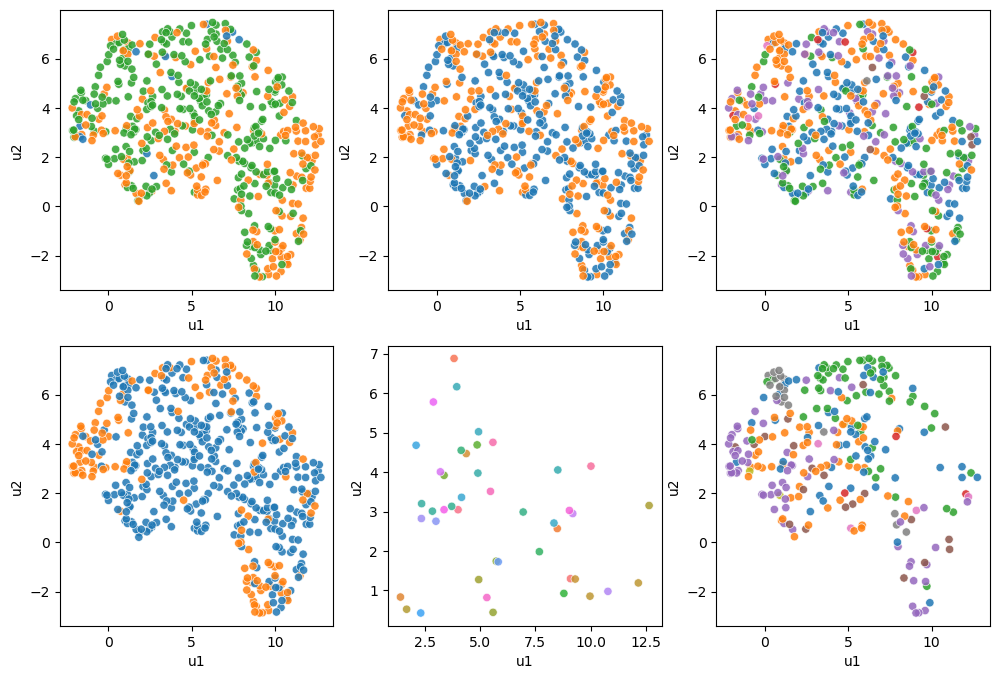

In [24]:
f,axes = plt.subplots(2,3, figsize=(12,8))
sbn.scatterplot(data=df, x='u1', y='u2', hue='specimenType', ax=axes.flatten()[0], legend=False, alpha=0.85, linewidth=0.5)
sbn.scatterplot(data=df, x='u1', y='u2', hue='consensus_sex', ax=axes.flatten()[1], legend=False, alpha=0.85, linewidth=0.5)
sbn.scatterplot(data=df, x='u1', y='u2', hue='ELN2017', ax=axes.flatten()[2], legend=False, alpha=0.85, linewidth=0.5)
sbn.scatterplot(data=df, x='u1', y='u2', hue='NPM1', ax=axes.flatten()[3], legend=False, alpha=0.85, linewidth=0.5)
sbn.scatterplot(data=df, x='u1', y='u2', hue='TP53', ax=axes.flatten()[4], legend=False, alpha=0.85, linewidth=0.5)
sbn.scatterplot(data=df, x='u1', y='u2', hue='fabBlastMorphology', ax=axes.flatten()[5], legend=False, alpha=0.85, linewidth=0.5)
plt.show()